In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
from os import listdir
import shutil
import csv

import torch
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw
import cv2 as cv
import seaborn as sns

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def atomBound(imgpath, bbpath):
  # part of boundBox and comparedBox
  rawimg = Image.open(imgpath)
  rawimg = rawimg.convert("RGB")
  postimg = ImageDraw.ImageDraw(rawimg)
  w,h = rawimg.size
  with open(bbpath) as bboxloc:
    reader = csv.reader(bboxloc)
    for i, rows in enumerate(reader):
        postimg.rectangle(((float(rows[0])*w - float(rows[2])*w/2, float(rows[1])*h - 
                                       float(rows[3])*h/2), (float(rows[0])*w + float(rows[2])*w/2, float(rows[1])*h + float(rows[3])*h/2)), fill=None, outline='red', width=1)
  
  return rawimg, postimg

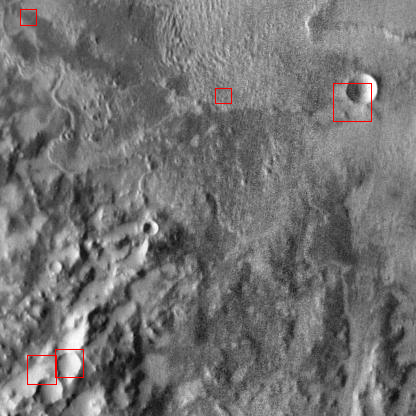

In [ ]:
def boundBox(imgpath, bbpath, outpath):
  # output rected img to a folder
  rawimg, postimg = atomBound(imgpath, bbpath)
  rawimg.save(outpath)
  display(rawimg)

boundBox('/content/drive/MyDrive/Boxuan/tripOri.png', '/content/drive/MyDrive/Boxuan/tripPred.csv', '/content/drive/MyDrive/Boxuan/images/triOutTest1.jpg')

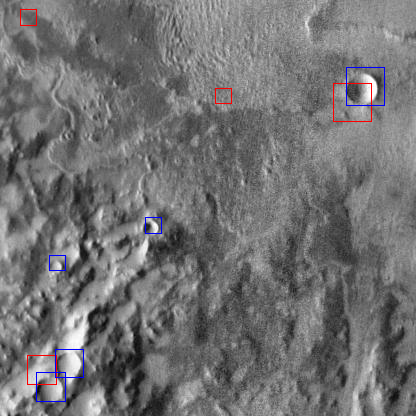

In [ ]:
def comparedBox(imgpath, bbpath, tbpath, outpath):
  # output compared img to a folder
  rawimg, postimg = atomBound(imgpath, bbpath)
  w,h = rawimg.size
  with open(tbpath) as tboxloc:
    reader = csv.reader(tboxloc)
    for i, rows in enumerate(reader):
        postimg.rectangle(((float(rows[0])*w - float(rows[2])*w/2, float(rows[1])*h - 
                                       float(rows[3])*h/2), (float(rows[0])*w + float(rows[2])*w/2, float(rows[1])*h + float(rows[3])*h/2)), fill=None, outline='blue', width=1)
  rawimg.save(outpath)
  display(rawimg)

comparedBox('/content/drive/MyDrive/Boxuan/tripOri.png', '/content/drive/MyDrive/Boxuan/tripPred.csv', '/content/drive/MyDrive/Boxuan/tripTruth.csv', '/content/drive/MyDrive/Boxuan/images/triOutTest2.jpg')

In [ ]:
def iouCal(x1, y1, x2, y2, w1, h1, w2, h2):
  # part of tripleStatic
  if abs(x1-x2) >= ((w1+w2)/2) or abs(y1-y2) >= ((h1+h2)/2):
    return 0
  else: 
    return (((w1+w2)/2 - abs(x1-x2)) * ((h1+h2)/2 - abs(y1-y2))) / (w1*h1 + w2*h2 - (((w1+w2)/2 - abs(x1-x2)) * ((h1+h2)/2 - abs(y1-y2))))


In [ ]:
def tripleStatic(bbpath, tbpath, outpath, threshold=0.5):
  # output TP-FP-FN csv file to a folder
  crtP = []
  crtT = []

  with open(bbpath) as bboxloc:
    reader = csv.reader(bboxloc)
    for i, rows in enumerate(reader):
      crtP.append([float(rows[0]), float(rows[1]), float(rows[2]), float(rows[3])])

  with open(tbpath) as tboxloc:
    reader = csv.reader(tboxloc)
    for i, rows in enumerate(reader):
      crtT.append([float(rows[0]), float(rows[1]), float(rows[2]), float(rows[3])])
  TP = 0
  FP = 0
  FN = 0
  for i in range(0, len(crtP)):
    temiouPeak = 0
    for o in range(0, len(crtT)):
      temiou = iouCal(crtP[i][0], crtP[i][1], crtT[o][0], crtT[o][1], crtP[i][2], crtP[i][3], crtT[o][2], crtT[o][3])
      print(temiou)
      if temiou >= temiouPeak:
        temiouPeak = temiou
    if temiouPeak >= threshold:
      TP = TP + 1
    else:
      FP = FP + 1
  FN = len(crtT) - TP

  triOut = [[TP, FP, FN]]
  triName=['TP','FP','FN']
  triCsv=pd.DataFrame(columns=triName,data=triOut)
  triCsv.to_csv(outpath)
  return TP, FP, FN

print(tripleStatic('/content/drive/MyDrive/Boxuan/pred_labels_of_aeolis_30_6.csv', '/content/drive/MyDrive/Boxuan/truth_labels_of_aeolis_30_6.csv', '/content/drive/MyDrive/Boxuan/statistics/triOutEva.csv'))

1.127208105717524
0
0
1.0879520872159658
(2, 0, 0)


In [13]:
def to_coords(imgpath, lat, lon, bbpath, R, image_scale):
    '''
    Converts coordinates from the format [0,1] to latitude and longitude for a given 
    location at the centre of the image.
    
    Parameters
    -------------
    x: x coordinate for crater location in [0,1]
    y: y coordinate for crater location in [0,1]
    w: width of the rectangle fitting around the crater in [0,1]
    h: height of the rectangle fitting around the crater in [0,1]
    lat_centre: latitude of the location at the centre of the image
    lon_centre: longitude of the location at the centre of the image
    lat_range: height of the image in degrees latitude
    lon_range: width of the image in degrees longitude
    
    Returns
    --------------
    Coordinates x, y of the crater location in longitude and latitude 
    Width w and height h of the rectangle fitting around the crater in degrees latitude and longitude

    This function is called in ...
    
    '''
    crtP = []
    rawimg = Image.open(imgpath)
    imgW,imgH = rawimg.size

    with open(bbpath) as bboxloc:
      reader = csv.reader(bboxloc)
      for i, rows in enumerate(reader):
        crtP.append(rows[:4])
        crtP[i] += ([float(rows[0])*imgW*image_scale + lon, lat - float(rows[1])*imgH*image_scale , (max(float(rows[2])*imgW, float(rows[3])*imgH)*image_scale*R)])

    with open(bbpath, 'w', newline='') as file:
      writer = csv.writer(file)
      writer.writerows(crtP)

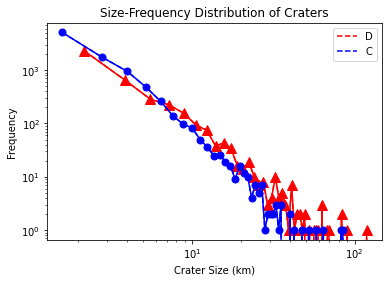

In [8]:
def plot_frequency_distribution(imgpath, bbpath, R, image_scale, outpath, tbpath = 'None'):   
    df = pd.read_csv(bbpath, header = None)
    rawimg = Image.open(imgpath)
    w,h = rawimg.size
    values = (df[[2, 3]].max(axis=1))*w*image_scale*R

    hist, bins = np.histogram(values, bins=70)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    plt.xlabel("Crater Size (km)")
    plt.ylabel("Frequency")
    plt.title("Size-Frequency Distribution of Craters")
    label1=plt.plot(bin_centers,hist,'r--',label='D')


    plt.loglog(bin_centers, hist, 'r^-', markersize=10, markeredgecolor='r')
    if tbpath != 'None':   
      df2 = pd.read_csv(tbpath, header = None)
      values2 = (df2[[2, 3]].max(axis=1))*w*image_scale*R
      hist2, bins2 = np.histogram(values2, bins=70)
      bin_centers2 = (bins2[:-1] + bins2[1:]) / 2
      plt.loglog(bin_centers2, hist2, 'bo-', markersize=7, markeredgecolor='b')
      label2=plt.plot(bin_centers2,hist2,'b--',label='C')

    
    plt.legend()
    plt.savefig(outpath)
    plt.show()

plot_frequency_distribution('/content/drive/MyDrive/Boxuan/tripOri.png', '/content/drive/MyDrive/Boxuan/Lunar_D_cut.csv', 1737.4, 0.001, '/content/drive/MyDrive/Boxuan/statistics/triOutFeq.png', '/content/drive/MyDrive/Boxuan/Lunar_C_cut.csv')